simple rag

In [2]:
from pinecone import Pinecone
import pickle
from rag.pinecone_query import PineconeRetriever
from rag.pipeline import RAG_Piepline
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY

pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "textbook-rag"
mapping_path = "data/chunks/mapping.pickle"
embedding_mdl = "multilingual-e5-large"
k = 3

with open(mapping_path, 'rb') as f:
    mapping = pickle.load(f)

retriever = PineconeRetriever(pc=pc, index_name=index_name, embedding_mdl=embedding_mdl, k=k, mapping=mapping)
rag = RAG_Piepline(retriever, GROQ_API_KEY, LANGCHAIN_API_KEY)

In [3]:
reply = rag.get_response("List some uses of ultrasound")
print(reply)

Some uses of ultrasound are:

1. Cleaning parts located in hard-to-reach places.
2. Detecting cracks and flaws in metal blocks.
3. Echocardiography (forming the image of the heart).
4. Getting images of internal organs of the human body.
5. Detecting abnormalities, such as stones or tumours in different organs.


agent

content='1' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 1509, 'total_tokens': 1512, 'completion_time': 0.003261097, 'prompt_time': 0.065936491, 'queue_time': 0.015578599999999998, 'total_time': 0.069197588}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None} id='run-549b08a1-a125-4777-8184-48d2a4829336-0' usage_metadata={'input_tokens': 1509, 'output_tokens': 3, 'total_tokens': 1512}
The effect of frequency on a sound wave is that the faster the vibration of the source, the higher is the frequency and the higher is the pitch.
0.838865519


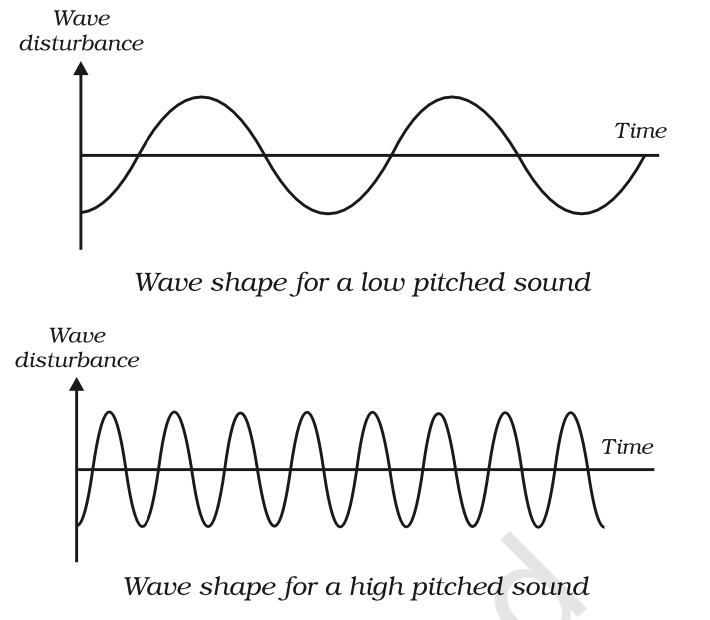

In [9]:
from agent.agent import Agent
from rag.pinecone_query import PineconeRetriever
from pinecone import Pinecone
import pickle
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from rag.pinecone_query import PineconeImageRetriever
from PIL import Image

pc = Pinecone(api_key=PINECONE_API_KEY)
text_index_name = "textbook-rag"
image_index_name = "textbook-rag-images"
mapping_path = "data/chunks/mapping.pickle"
embedding_mdl = "multilingual-e5-large"
text_k = 3
img_k = 1
img_fldr = "data/img_data/imgs/"
mapping_csv_path = "data/img_data/index.txt"

with open(mapping_path, 'rb') as f:
    mapping = pickle.load(f)

retriever = PineconeRetriever(pc=pc, index_name=text_index_name, embedding_mdl=embedding_mdl, k=text_k, mapping=mapping)
img_retr = PineconeImageRetriever(pc, image_index_name, img_fldr, mapping_csv_path)


agent = Agent(GROQ_API_KEY, LANGCHAIN_API_KEY, retriever, img_retr, model="mixtral-8x7b-32768")
reply, img_data = agent.query("What is the effect of frequency on sound wave")
print(reply)

if(img_data[0] is not None):
    print(img_data[1][0])
    display(Image.open(img_data[0][0]))

img stuff

[0.816541]


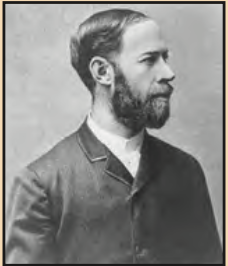

In [1]:
from rag.pinecone_query import PineconeImageRetriever
from pinecone import Pinecone
import pickle
from rag.pinecone_query import PineconeRetriever
from rag.pipeline import RAG_Piepline
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from PIL import Image

pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "textbook-rag-images"
img_fldr = "data/img_data/imgs/"
mapping_csv_path = "data/img_data/index.txt"
embedding_mdl = "multilingual-e5-large"

img_retr = PineconeImageRetriever(pc, index_name, img_fldr, mapping_csv_path)
img_path, img_scr = img_retr.get_relevant_image("mr hertz")

print(img_scr)
Image.open(img_path[0])

In [40]:
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Literal
from data.summaries.sound_summary import SOUND_SUMMARY

class RagRouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["use RAG vectorstore", "use LLM directly"] = Field(
        ...,
        description="Given a user question choose to route it to RAG dataase (1) or a direct response from LLM (0).",
    )

model='llama-3.1-8b-instant'
llm = ChatGroq(model=model, temperature=0, max_retries=2, api_key=GROQ_API_KEY)
structured_llm_router = llm.with_structured_output(RagRouteQuery)

message = """Hey"""

structured_llm_router.invoke(prompt.format(message, SOUND_SUMMARY))

RouteQuery(datasource='use LLM directly')

In [42]:
llm.invoke('hey')

AIMessage(content="How's it going? Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 36, 'total_tokens': 57, 'completion_time': 0.028, 'prompt_time': 0.008988813, 'queue_time': 0.005148886, 'total_time': 0.036988813}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-4e97b0d4-ac26-412c-9d9d-53380ea22163-0', usage_metadata={'input_tokens': 36, 'output_tokens': 21, 'total_tokens': 57})

In [39]:
out = structured_llm_router.invoke(prompt.format(message, SOUND_SUMMARY))
out.datasource

'use RAG vectorstore'

use RAG vectorstore
iters left: 3
A hearing aid is an electronic, battery-operated device that amplifies sound to assist people with hearing loss. It consists of a microphone, which captures sound waves and converts them into electrical signals, an amplifier that increases the strength of these signals, and a speaker that transforms the amplified signals back into sound. This sound is then directed into the ear canal, enhancing the user's ability to hear clearly. The device is designed to improve communication and daily life for those who struggle with hearing. The image shown, featuring a megaphone and a horn, illustrates how sound can be amplified and directed, much like a hearing aid amplifies and directs sound into the ear for clearer hearing.
0.8254776


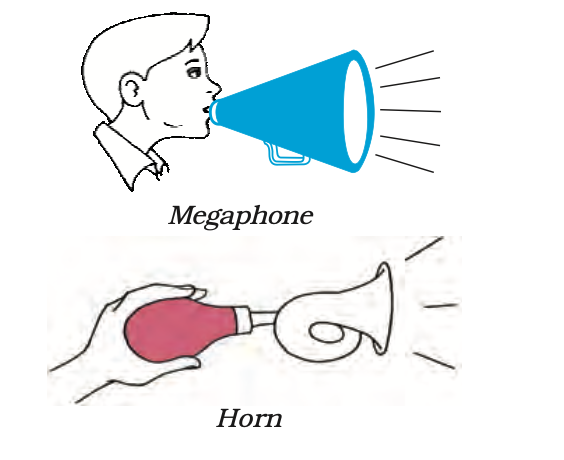

In [7]:
from agent.agent import Agent
from rag.pinecone_query import PineconeRetriever
from pinecone import Pinecone
import pickle
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from rag.pinecone_query import PineconeImageRetriever
from PIL import Image

pc = Pinecone(api_key=PINECONE_API_KEY)
text_index_name = "textbook-rag"
image_index_name = "textbook-rag-images"
mapping_path = "data/chunks/mapping.pickle"
embedding_mdl = "multilingual-e5-large"
text_k = 3
img_k = 1
img_fldr = "data/img_data/imgs/"
mapping_csv_path = "data/img_data/index.txt"

with open(mapping_path, 'rb') as f:
    mapping = pickle.load(f)

retriever = PineconeRetriever(pc=pc, index_name=text_index_name, embedding_mdl=embedding_mdl, k=text_k, mapping=mapping)
img_retr = PineconeImageRetriever(pc, image_index_name, img_fldr, mapping_csv_path)


agent = Agent(GROQ_API_KEY, LANGCHAIN_API_KEY, retriever, img_retr, model="llama3-groq-70b-8192-tool-use-preview")
reply, img_data = agent.query("Whats a hearing aid")
print(reply)

if(img_data[0] is not None):
    print(img_data[1])
    display(Image.open(img_data[0]))

In [6]:
from rag.pipeline import ReActRAG 
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from rag.pinecone_query import PineconeImageRetriever
from agent.agent import Agent
from rag.pinecone_query import PineconeRetriever
from pinecone import Pinecone
import pickle
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from rag.pinecone_query import PineconeImageRetriever
from PIL import Image
from pinecone import Pinecone
import pickle
from rag.pinecone_query import PineconeRetriever
from rag.pipeline import RAG_Piepline
from config import PINECONE_API_KEY, GROQ_API_KEY, LANGCHAIN_API_KEY
from langchain_groq import ChatGroq

pc = Pinecone(api_key=PINECONE_API_KEY)
text_index_name = "textbook-rag"
image_index_name = "textbook-rag-images"
mapping_path = "data/chunks/mapping.pickle"
embedding_mdl = "multilingual-e5-large"
text_k = 3
img_k = 1
img_fldr = "data/img_data/imgs/"
mapping_csv_path = "data/img_data/index.txt"
with open(mapping_path, 'rb') as f:
    mapping = pickle.load(f)
model="llama3-groq-70b-8192-tool-use-preview"


retriever = PineconeRetriever(pc=pc, index_name=text_index_name, embedding_mdl=embedding_mdl, k=text_k, mapping=mapping)
generator_llm = ChatGroq(model=model, temperature=1, max_retries=2, api_key=GROQ_API_KEY)
router_llm = ChatGroq(model=model, temperature=0, max_retries=2, api_key=GROQ_API_KEY)

agent = ReActRAG(retriever, generator_llm, router_llm, LANGCHAIN_API_KEY)

agent.get_response('Whats the speed of light and sound')


iters left: 3
lookup:
 What is the speed of light in vacuum?
What is the speed of sound in air?
What is the speed of light and sound in different mediums?
What are the values of speed of light and sound in vacuum and air?
context:
 m s–2 and speed of sound = 340 m s–1. • Sound properties such as pitch, loudness and quality are determined by the corresponding wave properties. Rationalised 2023-24 SOUND 139 13. A sound wave travels at a speed of 339 m s–1. If its wavelength is 1.5 cm, what is the frequency of the wave? Will it be audible? 14. What is reverberation? How can it be reduced? 15. What is loudness of sound? What factors does it depend on? 16. How is ultrasound used for cleaning? 17. Explain how defects in a metal block can be detected using ultrasound. Rationalised 2023-24

s using chart paper. The length of the pipes should be sufficiently long as shown. • Arrange them on a table near a wall. • Keep a clock near the open end of one of the pipes and try to hear the sound of th

'The speed of light is approximately 3 × 10^8 m s–1 in a vacuum. The speed of sound in air at a temperature of 25°C is 346 m s–1.'